In [4]:
import awkward as ak
import numpy as np
import hist as hs
from coffea import processor, hist as chs
from coffea.nanoevents.methods import vector, candidate

from coffea.nanoevents import BaseSchema
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(mplhep.style.CMS)

In [95]:
class LLP_ntuple_processor(processor.ProcessorABC):
    """
    This class is used to process the ntuples created by the LLP ntuple producer.
    """
    def process(self, events):
        """
        This function is used to process the ntuples into histograms.
        :param events:
        :return:
        """

        # create a dictionary for storing dimensions of different parts of the detector
        detector_dimensions = {
            'csc': {},
            'dt': {},
            'cms': {},
        }

        # fill detector_dimensions with the dimensions of the different parts of the detector
        s = 1e2  # scale factor
        detector_dimensions['csc']['zmin'] = s * 5.5
        detector_dimensions['csc']['zmax'] = s * 10.
        detector_dimensions['csc']['rmin'] = s * 0.
        detector_dimensions['csc']['rmax'] = s * 7.
        detector_dimensions['dt']['zmin'] = s * 0.
        detector_dimensions['dt']['zmax'] = s * 6.5
        detector_dimensions['dt']['rmin'] = s * 4.
        detector_dimensions['dt']['rmax'] = s * 7.5

        detector_dimensions['cms']['zmin'] = s * 0.
        detector_dimensions['cms']['zmax'] = s * 16.
        detector_dimensions['cms']['rmin'] = s * 0.
        detector_dimensions['cms']['rmax'] = s * 12.

        dataset = events.metadata['dataset']
        sumw = ak.sum(events.genWeight)

        out = {
            dataset: {
                "entries": len(events),
                "sumw": sumw,
            }
        }

        def R(x, y):
            """
            computes radius
            :param x:
            :param y:
            :return:
            """
            return np.sqrt(x ** 2 + y ** 2)

        # simple if statement that assigns a variable 'pid' to 9900015 or 1000023 if any of the events has one of
        # those particles
        if ak.any(events.gParticleId == 9900015): pid = 9900015
        if ak.any(events.gParticleId == 1000023): pid = 1000023

        # we need the decay vertices of the llps but events doesn't have that information. but we do have access to
        # the id of the mother particles (gParticleMotherId) as well as production vertices of all particles (
        # gParticleProdVertexX, gParticleProdVertexY, gParticleProdVertexZ) Make a mask of the particles whose mother
        # is the llp
        mother_llp_mask = events.gParticleMotherId == pid
        # However, each llp will have multiple products, so events.gParticleProdVertexX[mother_llp_mask] will have
        # duplicates To remove the duplicates we can use a trick that uses ak.argmax to find the index of the first
        # occurrence of each truth value Make an awkward array of the indices of the first occurrence of each truth
        # value within the second level of the mask
        llp_daughter_index = ak.argmax(mother_llp_mask, axis=1, keepdims=True)
        # Now we can use llp_daughter_index to get the indexes of the llps themselves using gParticleMotherIndex
        llp_index = events.gParticleMotherIndex[llp_daughter_index]

        # make a zip of the llp decay vertices and PtEtaPhiMLorentzVector
        cms_llps = ak.zip(
            {
                'X': events.gParticleProdVertexX[llp_daughter_index],
                'Y': events.gParticleProdVertexY[llp_daughter_index],
                'Z': events.gParticleProdVertexZ[llp_daughter_index],
                'R': R(events.gParticleProdVertexX[llp_daughter_index],
                       events.gParticleProdVertexY[llp_daughter_index]),
                'pt': events.gParticlePt[llp_index],
                'phi': events.gParticlePhi[llp_index],
                'eta': events.gParticleEta[llp_index],
                'mass': ak.ones_like(events.gParticlePt[llp_index]),
                'E': events.gParticleE[llp_index],
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do the same with cscRechitCluster
        csc_cls = ak.zip(
            {
                'X': events.cscRechitClusterX,
                'Y': events.cscRechitClusterY,
                'Z': events.cscRechitClusterZ,
                'R': R(events.cscRechitClusterX, events.cscRechitClusterY),
                'pt': ak.ones_like(events.cscRechitClusterPhi),
                'phi': events.cscRechitClusterPhi,
                'eta': events.cscRechitClusterEta,
                'mass': ak.ones_like(events.cscRechitClusterPhi),
                'E': ak.ones_like(events.cscRechitClusterPhi),
                'NRechitChamberPlus11': events.cscRechitClusterNRechitChamberPlus11,    
                'NRechitChamberPlus12': events.cscRechitClusterNRechitChamberPlus12,
                'NRechitChamberMinus11': events.cscRechitClusterNRechitChamberMinus11,
                'NRechitChamberMinus12': events.cscRechitClusterNRechitChamberMinus12,
                'TimeSpread': events.cscRechitClusterTimeSpread,
                'TimeTotal': events.cscRechitClusterTimeTotal,
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do exactly the same with dtRechitCluster
        dt_cls = ak.zip(
            {
                'X': events.dtRechitClusterX,
                'Y': events.dtRechitClusterY,
                'Z': events.dtRechitClusterZ,
                'R': R(events.dtRechitClusterX, events.dtRechitClusterY),
                'pt': ak.ones_like(events.dtRechitClusterPhi),
                'phi': events.dtRechitClusterPhi,
                'eta': events.dtRechitClusterEta,
                'mass': ak.ones_like(events.dtRechitClusterPhi),
                'E': ak.ones_like(events.dtRechitClusterPhi),
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do exactly the same with cscRechits
        csc_rechits = ak.zip(
            {
                'X': events.cscRechitsX,
                'Y': events.cscRechitsY,
                'Z': events.cscRechitsZ,
                'R': R(events.cscRechitsX, events.cscRechitsY),
                'pt': ak.ones_like(events.cscRechitsPhi),
                'phi': events.cscRechitsPhi,
                'eta': events.cscRechitsEta,
                'mass': ak.ones_like(events.cscRechitsPhi),
                'E': ak.ones_like(events.cscRechitsPhi),
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        # do exactly the same with dtRechits
        dt_rechits = ak.zip(
            {
                'X': events.dtRechitX,
                'Y': events.dtRechitY,
                'Z': events.dtRechitZ,
                'R': R(events.dtRechitX, events.dtRechitY),
                'pt': ak.ones_like(events.dtRechitPhi),
                'phi': events.dtRechitPhi,
                'eta': events.dtRechitEta,
                'mass': ak.ones_like(events.dtRechitPhi),
                'E': ak.ones_like(events.dtRechitPhi),
            },
            with_name='PtEtaPhiMLorentzVector',
            behavior=vector.behavior,
        )

        def csc_cut(v):
            """
            takes a PtEtaPhiMLorentzVector and returns a PtEtaPhiMLorentzVector with cuts in the csc region
            :param v:
            :return:
            """
            dims = detector_dimensions['csc']
            cut = (
                    (abs(v.eta) < 2.4) &
                    (abs(v.Z) > dims['zmin']) & (abs(v.Z) < dims['zmax']) &
                    (v.R < dims['rmax'])
            )
            return v[cut]

        def dt_cut(v):
            """
            takes a PtEtaPhiMLorentzVector and returns a PtEtaPhiMLorentzVector with cuts in the dt region
            :param v:
            :return:
            """
            dims = detector_dimensions['dt']
            cut = (
                    (v.R > dims['rmin']) & (v.R < dims['rmax']) &
                    (abs(v.Z) < dims['zmax'])
            )
            return v[cut]

        def muonsys_cut(v):
            """
            takes a PtEtaPhiMLorentzVector and returns a PtEtaPhiMLorentzVector with cuts in the muonsys region
            :param v:
            :return:
            """
            dims = detector_dimensions['csc']
            csc_cut = (
                    (abs(v.eta) < 2.4) &
                    (abs(v.Z) > dims['zmin']) & (abs(v.Z) < dims['zmax']) &
                    (v.R < dims['rmax'])
            )
            dims = detector_dimensions['dt']
            dt_cut = (
                    (v.R > dims['rmin']) & (v.R < dims['rmax']) &
                    (abs(v.Z) < dims['zmax'])
            )
            return v[csc_cut | dt_cut]

        def ME1112_veto(v):
            """
            takes a PtEtaPhiMLorentzVector csc_cls and returns a PtEtaPhiMLorentzVector csc_cls with ME1112 vetos
            :param v:
            :return:
            """
            cut = (
                    (v.NRechitChamberPlus11 <= 0) &
                    (v.NRechitChamberPlus12 <= 0) &
                    (v.NRechitChamberMinus11 <= 0) &
                    (v.NRechitChamberMinus12 <= 0)
            )
            return v[cut]

        def timeSpread_cut(v):
            """
            takes a PtEtaPhiMLorentzVector csc_cls and returns a PtEtaPhiMLorentzVector csc_cls with time spread cut
            :param v:
            :return:
            """
            cut = (v.TimeSpread <= 20)
            return v[cut]

        def time_cut(v):
            """
            takes a PtEtaPhiMLorentzVector csc_cls and returns a PtEtaPhiMLorentzVector csc_cls with time cut
            :param v:
            :return:
            """
            cut = (v.TimeTotal < 12.5) & (v.TimeTotal > -5)
            return v[cut]

        def eta_cut(v):
            """
            takes a PtEtaPhiMLorentzVector and returns a PtEtaPhiMLorentzVector with eta cut
            :param v:
            :return:
            """
            cut = (abs(v.eta) < 2)
            return v[cut]

        def cartesian_delta_r(v1, v2):
            """
            takes two PtEtaPhiMLorentzVector awkward arrays and returns all the combinations of
            pairs and deltaR's
            :param v1:
            :param v2:
            :return:
            """
            # ensure that the key and the name of the variable are the same for consistency
            # this is probably bad practice, but it works
            v1name = [k for k, v in locals().items() if v is v1][0]
            v2name = [k for k, v in locals().items() if v is v2][0]
            pairs = ak.cartesian({v1name: v1, v2name: v2}, axis=1, nested=True)
            delta_r = pairs.v1.delta_r(pairs.v2)
            return ak.zip(
                {
                    'delta_r': delta_r,
                    v1name: pairs.v1,
                    v2name: pairs.v2,
                },
            )

        def delta_r_cut(v, threshold):
            """
            takes pairs and returns pairs with delta_r < threshold
            :param v:
            :param threshold:
            :return:
            """
            cut = v.delta_r < threshold
            return v[cut]

        def init_2d_hist(bins):
            """
            takes a number of bins and returns a 2D histogram with those bins within the cms region
            :param bins:
            :return:
            """
            dims = detector_dimensions['cms']
            return (
                hs.Hist.new
                    .Reg(bins, dims['zmin'], dims['zmax'], name='z', label='z [cm]')
                    .Reg(bins, dims['rmin'], dims['rmax'], name='r', label='r [cm]')
                    .Double()
            )

        def fill_2d_hist(hist, v):
            """
            takes a 2D histogram and a PtEtaPhiMLorentzVector and fills it
            :param hist:
            :param v:
            :return:
            """
            z = abs(ak.flatten(v.Z, axis=None))
            r = abs(ak.flatten(v.R, axis=None))
            hist.fill(z=z, r=r)

        def init_fill_2d_hist(bins, v):
            """
            takes a number of bins and a PtEtaPhiMLorentzVector, then initializes and fills a 2D histogram with those bins
            :param bins:
            :param v:
            :return:
            """
            hist = init_2d_hist(bins)
            fill_2d_hist(hist, v)
            return hist

        def init_1d_hist(bins, domain, name, label):
            """
            takes a number of bins, a domain, a name, and a label and returns a 1D histogram with those bins
            :param bins:
            :param domain:
            :param name:
            :param label:
            :return:
            """
            return hs.Hist.new.Reg(bins, domain[0], domain[1], name=name, label=label).Double()

        def fill_1d_hist(hist, arr):
            """
            takes a 1D histogram and a flat array and fills it
            :param hist:
            :param arr:
            :return:
            """
            hist.fill(ak.flatten(arr, axis=None))

        def init_fill_1d_hist(bins, domain, arr, name, label):
            """
            takes a number of bins, a domain, a flat array, a name, and a label and initializes and fills a 1D
            histogram with those bins
            :param bins:
            :param hist:
            :param domain:
            :param arr:
            :param name:
            :param label:
            :return:
            """
            hist = init_1d_hist(bins, domain, name, label)
            fill_1d_hist(hist, arr)
            return hist
        
        # naming convention is as follows:
        # <region of>_<cluster or rechit>_<region of>_llps_pairs
        # cut cms_llps to detector regions
        csc_llps = csc_cut(cms_llps)
        dt_llps = dt_cut(cms_llps)
        muonsys_llps = muonsys_cut(cms_llps)

        # delta r pairs between cls and cms_llps
        csc_cls_cms_llp_pairs = cartesian_delta_r(csc_cls, cms_llps)
        dt_cls_cms_llp_pairs = cartesian_delta_r(dt_cls, cms_llps)

        # delta r's between cls and llps in region
        csc_cls_csc_llps_pairs = cartesian_delta_r(csc_cls, csc_llps)
        dt_cls_dt_llps_pairs = cartesian_delta_r(dt_cls, dt_llps)

        # delta r's between rechits and cms_llps
        csc_rechits_cms_llp_pairs = cartesian_delta_r(csc_rechits, cms_llps)
        dt_rechits_cms_llp_pairs = cartesian_delta_r(dt_rechits, cms_llps)

        # delta r's between rechits and llps in region
        csc_rechits_csc_llps_pairs = cartesian_delta_r(csc_rechits, csc_llps)
        dt_rechits_dt_llps_pairs = cartesian_delta_r(dt_rechits, dt_llps)

        # same as before but with delta_r < threshold
        # naming convention is as follows:
        # <region of>_<cluster or rechit>_<region of>_llps_pairs_dr_cut
        threshold = 0.4
        csc_cls_cms_llp_pairs_dr_cut = delta_r_cut(csc_cls_cms_llp_pairs, threshold)
        dt_cls_cms_llp_pairs_dr_cut = delta_r_cut(dt_cls_cms_llp_pairs, threshold)
        csc_cls_csc_llps_pairs_dr_cut = delta_r_cut(csc_cls_csc_llps_pairs, threshold)
        dt_cls_dt_llps_pairs_dr_cut = delta_r_cut(dt_cls_dt_llps_pairs, threshold)
        csc_rechits_cms_llp_pairs_dr_cut = delta_r_cut(csc_rechits_cms_llp_pairs, threshold)
        dt_rechits_cms_llp_pairs_dr_cut = delta_r_cut(dt_rechits_cms_llp_pairs, threshold)
        csc_rechits_csc_llps_pairs_dr_cut = delta_r_cut(csc_rechits_csc_llps_pairs, threshold)
        dt_rechits_dt_llps_pairs_dr_cut = delta_r_cut(dt_rechits_dt_llps_pairs, threshold)
        
        bins = 60
        hists1d = {
            'cms_llps':{}, 'csc_llps':{}, 'dt_llps':{},
            'csc_cls':{}, 'dt_cls':{},
            'csc_cls_csc_llps_pairs_dr_cut_csc_llps':{}, 'dt_cls_dt_llps_pairs_dr_cut_dt_llps':{},
        }

        hists1d['cms_llps']['E'] = init_fill_1d_hist(bins, (0, 120), cms_llps.E, 'E', 'E [GeV]')
        hists1d['cms_llps']['pt'] = init_fill_1d_hist(bins, (0, 120), cms_llps.pt, 'pt', 'pt [GeV]')
        hists1d['cms_llps']['eta'] = init_fill_1d_hist(bins, (-4, 4), cms_llps.eta, 'eta', 'eta')
        hists1d['cms_llps']['phi'] = init_fill_1d_hist(bins, (-4, 4), cms_llps.phi, 'phi', 'phi')

        hists1d['csc_llps']['E'] = init_fill_1d_hist(bins, (0, 120), csc_llps.E, 'E', 'E [GeV]')
        hists1d['csc_llps']['pt'] = init_fill_1d_hist(bins, (0, 120), csc_llps.pt, 'pt', 'pt [GeV]')
        hists1d['csc_llps']['eta'] = init_fill_1d_hist(bins, (-4, 4), csc_llps.eta, 'eta', 'eta')
        hists1d['csc_llps']['phi'] = init_fill_1d_hist(bins, (-4, 4), csc_llps.phi, 'phi', 'phi')

        hists1d['dt_llps']['E'] = init_fill_1d_hist(bins, (0, 120), dt_llps.E, 'E', 'E [GeV]')
        hists1d['dt_llps']['pt'] = init_fill_1d_hist(bins, (0, 120), dt_llps.pt, 'pt', 'pt [GeV]')
        hists1d['dt_llps']['eta'] = init_fill_1d_hist(bins, (-4, 4), dt_llps.eta, 'eta', 'eta')
        hists1d['dt_llps']['phi'] = init_fill_1d_hist(bins, (-4, 4), dt_llps.phi, 'phi', 'phi')

        hists1d['csc_cls_csc_llps_pairs_dr_cut_csc_llps']['E'] = init_fill_1d_hist(bins, (0, 120), csc_cls_csc_llps_pairs_dr_cut.v2.E, 'E', 'E [GeV]')

        hists2d = {
            'cms_llps':{}, 'csc_llps':{}, 'dt_llps':{}, 'muonsys_llps':{},
            'csc_cls':{}, 'dt_cls':{},
        }

        # fill 2d histograms    
        hists2d['cms_llps'] = init_fill_2d_hist(bins, cms_llps)
        hists2d['csc_llps'] = init_fill_2d_hist(bins, csc_llps)
        hists2d['dt_llps'] = init_fill_2d_hist(bins, dt_llps)
        hists2d['muonsys_llps'] = init_fill_2d_hist(bins, muonsys_llps)

        #v1 for the first object, v2 for the second object
        hists2d['csc_cls_csc_llps_pairs_dr_cut_csc_llps'] = init_fill_2d_hist(bins, csc_cls_csc_llps_pairs_dr_cut.v2)
        hists2d['dt_cls_dt_llps_pairs_dr_cut_dt_llps'] = init_fill_2d_hist(bins, dt_cls_dt_llps_pairs_dr_cut.v2)

        hists2d['csc_cls_csc_llps_pairs_dr_cut_csc_cls'] = init_fill_2d_hist(bins, csc_cls_csc_llps_pairs_dr_cut.v1)
        hists2d['dt_cls_dt_llps_pairs_dr_cut_dt_cls'] = init_fill_2d_hist(bins, dt_cls_dt_llps_pairs_dr_cut.v1)

        ## the following is for building an efficiency table, where each row is another cut added to csc_cls
        counts = {}
        
        csc_cls_time_cut = time_cut(csc_cls)
        csc_cls_ME1112_veto = ME1112_veto(csc_cls_time_cut)
        csc_cls_Eta_cut = eta_cut(csc_cls_ME1112_veto)
        csc_cls_timeSpread_cut = timeSpread_cut(csc_cls_Eta_cut)

        hists2d['csc_cls'] = init_fill_2d_hist(bins, csc_cls)
        hists2d['csc_cls_time_cut'] = init_fill_2d_hist(bins, csc_cls_time_cut)
        hists2d['csc_cls_ME1112_veto'] = init_fill_2d_hist(bins, csc_cls_ME1112_veto)
        hists2d['csc_cls_Eta_cut'] = init_fill_2d_hist(bins, csc_cls_Eta_cut)
        hists2d['csc_cls_timeSpread_cut'] = init_fill_2d_hist(bins, csc_cls_timeSpread_cut)

        out[dataset]['hists1d'] = hists1d
        out[dataset]['hists2d'] = hists2d
        return out

    def postprocess(self, accumulator):
        return accumulator

In [96]:
# digging up
def rootAdds(directory):
    my_file = open(directory, "r")
    data = my_file.read().strip()
    data_into_list = data.split("\n")
    my_file.close()
    return data_into_list

fileset = {}
fileset['hnl'] = rootAdds('notebooks/Bplus/rootAdds/BToHNL_MuonAndHNLGenFilter_mHNL1p0_ctau1000.txt')
#fileset['phi'] = rootAdds('notebooks/Bplus/rootAdds/BToKPhi_MuonGenFilter_mPhi1p0_ctau1000.txt')

out = processor.run_uproot_job(
    fileset,
    treename="ntuples/llp",
    processor_instance=LLP_ntuple_processor(),
    executor=processor.futures_executor,
    executor_args={"schema": BaseSchema, "workers": 6},
    #maxchunks = 3
)

Processing:   0%|          | 0/599 [00:00<?, ?chunk/s]

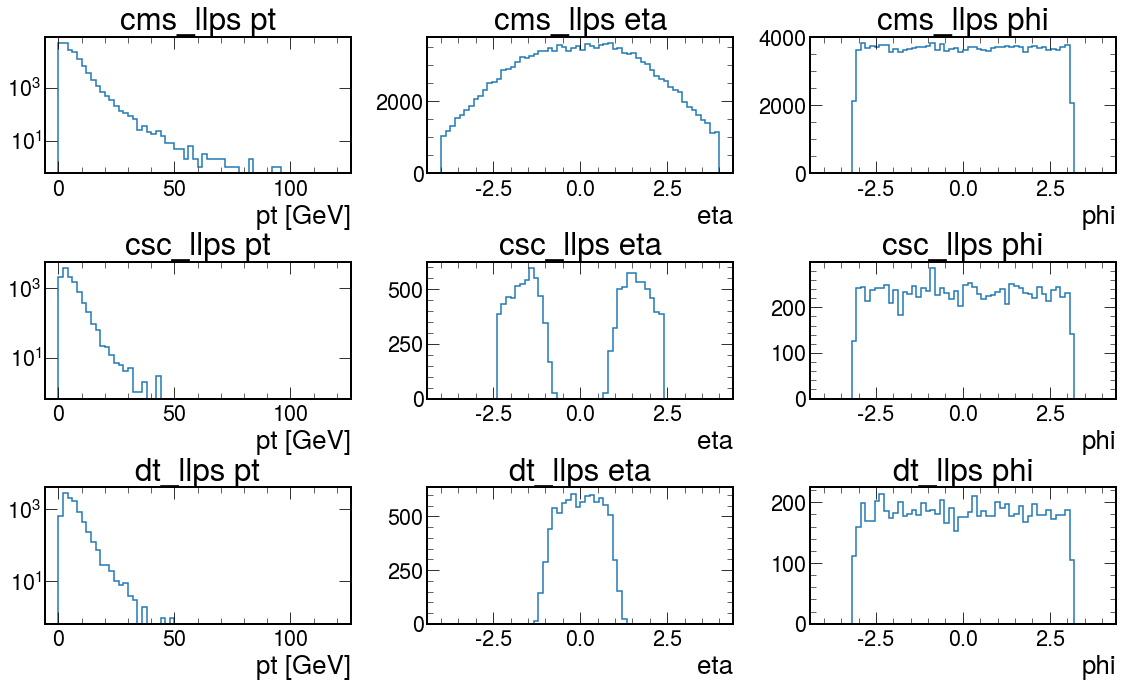

In [72]:
'''for region in out['hnl']['hists1d']:
    for hist in out['hnl']['hists1d'][region]:
        hep.histplot(out['hnl']['hists1d'][region][hist])
        plt.title(f'{region} {hist}')
        plt.show()'''

regs = ['cms_llps', 'csc_llps', 'dt_llps']
a=1.2
fig, ax = plt.subplots(len(regs),3, figsize=(16*a,9*a))
fig.subplots_adjust(wspace=.25, hspace=.65)

for i, reg in enumerate(regs):
    hep.histplot(out['hnl']['hists1d'][reg]['pt'],ax = ax[i,0])
    ax[i,0].set_yscale('log')
    ax[i,0].set_title(f'{reg} pt')

    hep.histplot(out['hnl']['hists1d'][reg]['eta'],ax = ax[i,1])
    ax[i,1].set_title(f'{reg} eta')

    hep.histplot(out['hnl']['hists1d'][reg]['phi'],ax = ax[i,2])
    ax[i,2].set_title(f'{reg} phi')
       

plt.show()




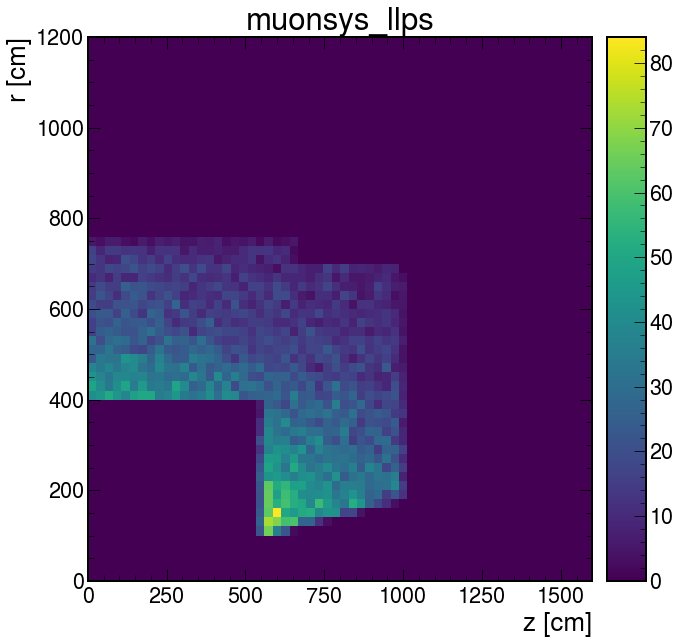

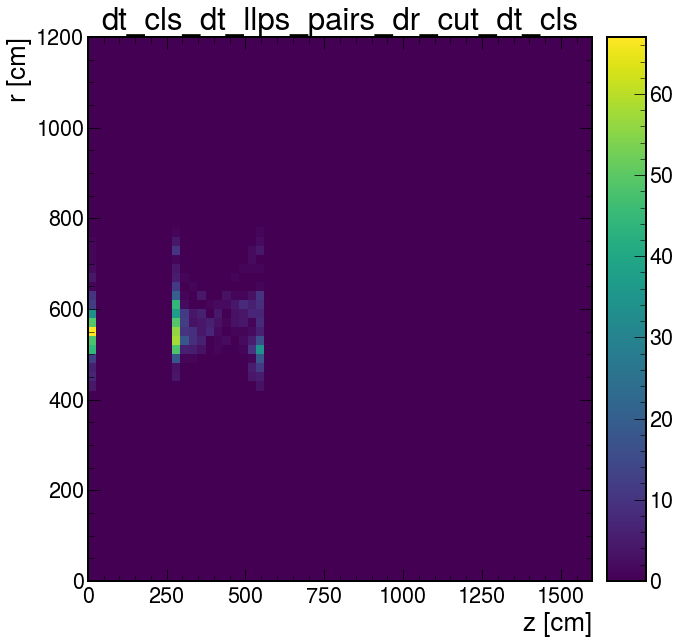

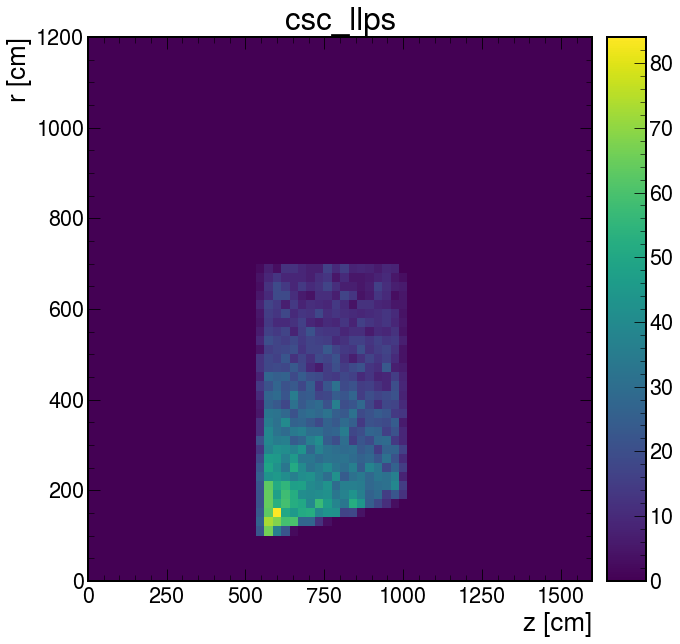

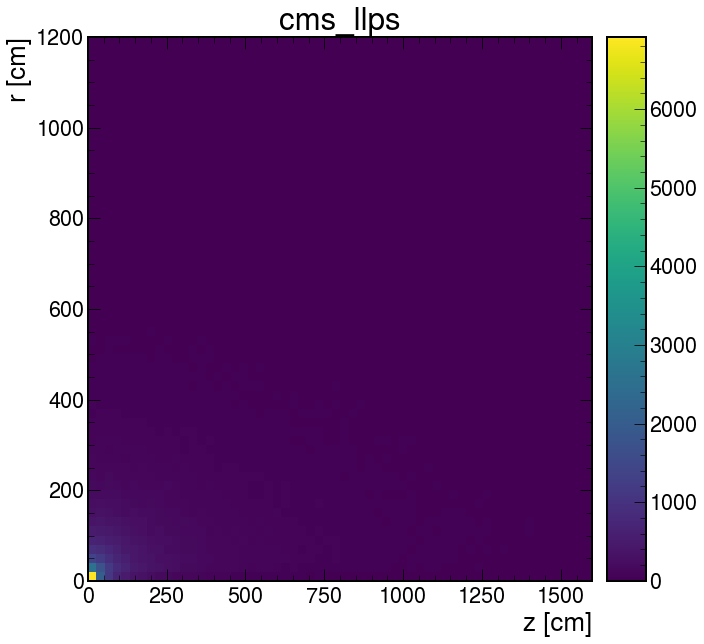

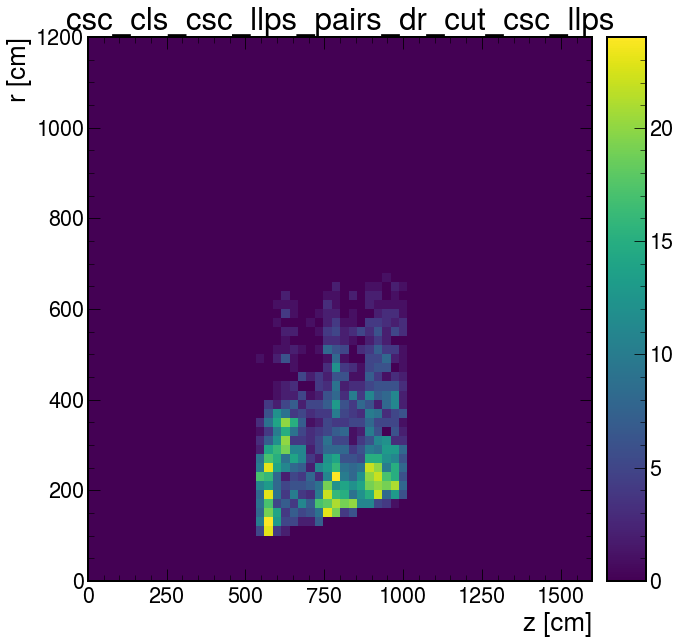

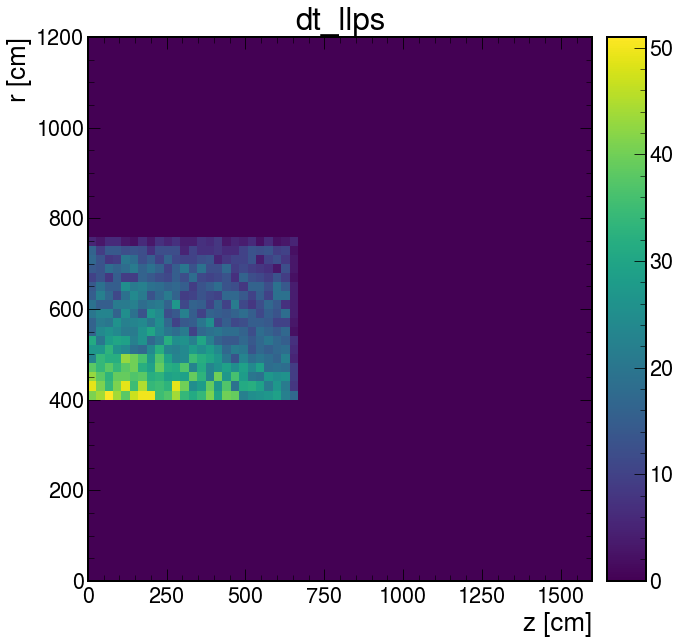

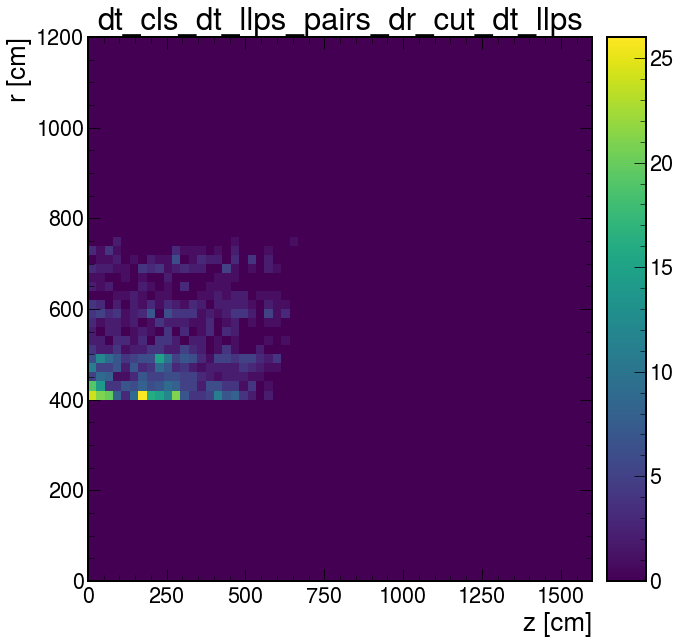

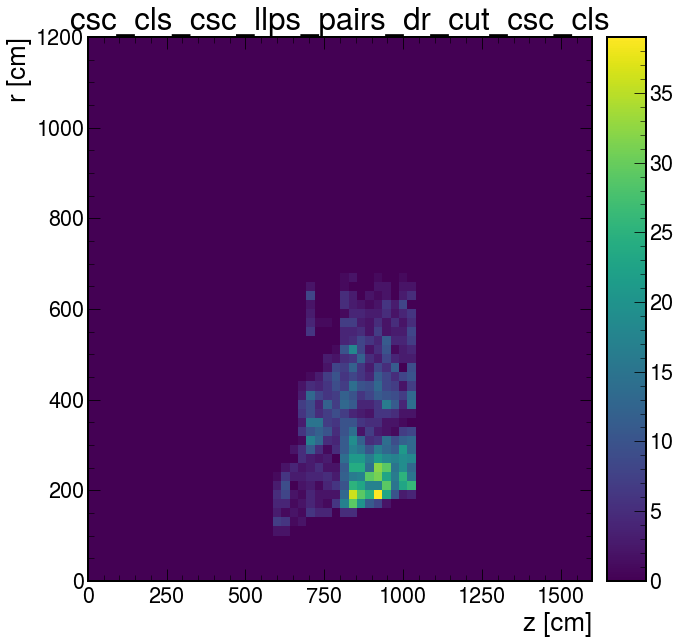

In [59]:
for region in out['hnl']['hists2d']:
    try:
        hep.hist2dplot(out['hnl']['hists2d'][region])
        plt.title(f'{region}')
        plt.show()
    except:
        pass




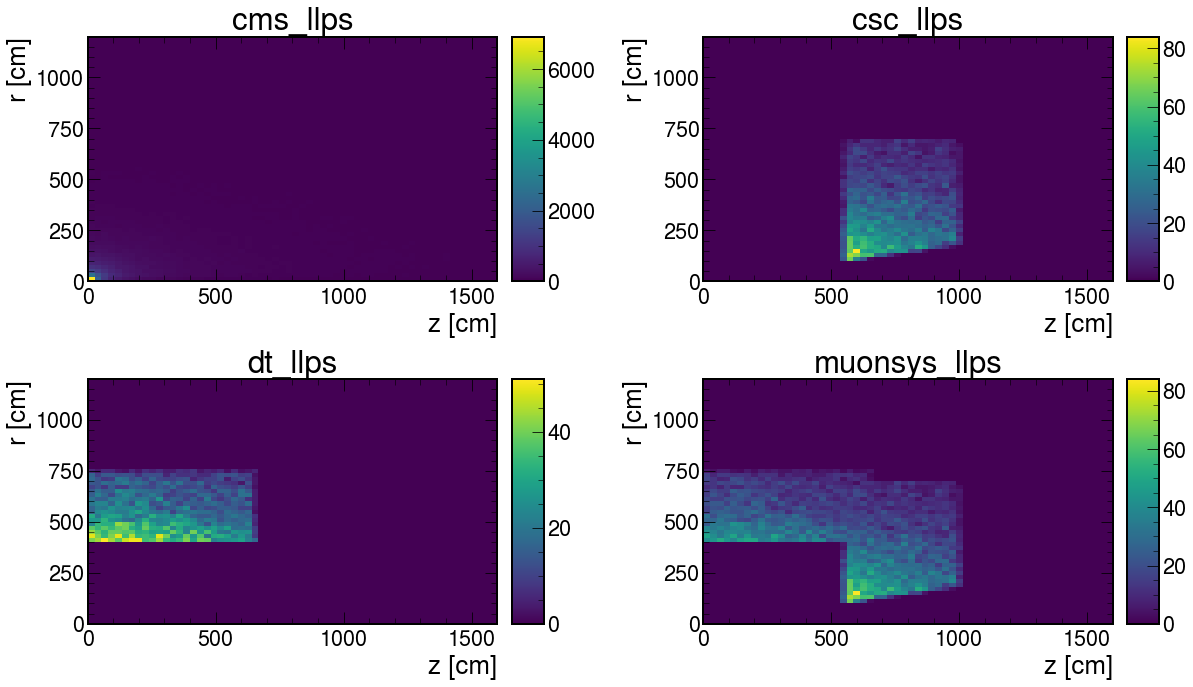

In [67]:
regs = ['cms_llps', 'csc_llps', 'dt_llps', 'muonsys_llps']
a=1.2
fig, axs = plt.subplots(2, 2, figsize=(16*a,9*a))
fig.subplots_adjust(wspace=.35, hspace=.4)
for ax, reg in zip(axs.reshape(-1),regs):
    hep.hist2dplot(out['hnl']['hists2d'][reg], ax = ax)
    ax.set_title(f'{reg}')
plt.show()

In [53]:
# I need a function that takes two histograms and returns a histogram with the ratio of the two
def ratio_hist(h1, h2):
    ratio = h1.copy()
    ratio[hs.underflow,hs.underflow] = 0
    ratio[hs.overflow,hs.overflow]  = 0
    ratio[hs.underflow,hs.overflow] = 0
    ratio[hs.overflow,hs.underflow]  = 0
    ratio = h1/h2
    ratio[:,:] = np.nan_to_num(ratio[:,:], nan = 0, posinf=0, neginf=0)

    return ratio

csc_ratio = ratio_hist(out['hnl']['hists2d']['csc_cls_csc_llps_pairs_dr_cut_csc_llps'], 
                          out['hnl']['hists2d']['csc_llps'])

dt_ratio = ratio_hist(out['hnl']['hists2d']['dt_cls_dt_llps_pairs_dr_cut_dt_llps'],
                            out['hnl']['hists2d']['dt_llps'])

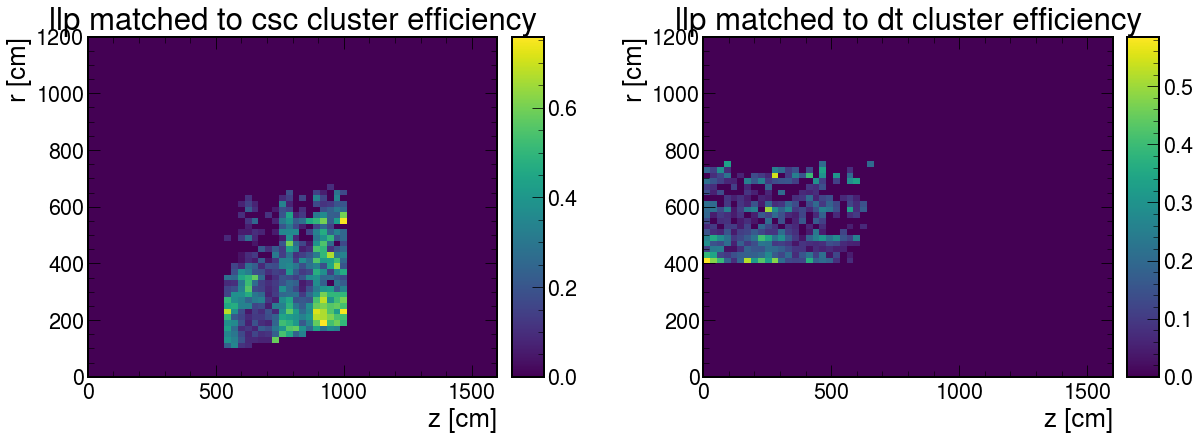

In [75]:
a=1.2
fig, ax = plt.subplots(1, 2, figsize=(16*a,9*a/2))
fig.subplots_adjust(top = 1 ,wspace=.35)
hep.hist2dplot(csc_ratio, ax = ax[0])
ax[0].set_title(f'llp matched to csc cluster efficiency')
hep.hist2dplot(dt_ratio, ax = ax[1])
ax[1].set_title(f'llp matched to dt cluster efficiency')
plt.show()


In [121]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(reco, real, rax, ax, det):
    num = reco.project(ax)
    den = real.project(ax)
    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "efficiency"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    rax.set_ylabel(f"{det} Cluster Efficiency")
    rax.set_xlabel(f"LLP decay {ax}[cm]")
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-140,y_max*0.9, "Inner ring", fontsize=15)
    ax.text(350+150 ,y_max*0.9, "Outer ring", fontsize=15)
    return ax

/tmp/ipykernel_30056/2400466793.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_30056/2400466793.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


<AxesSubplot:xlabel='LLP decay r[cm]', ylabel='csc Cluster Efficiency'>

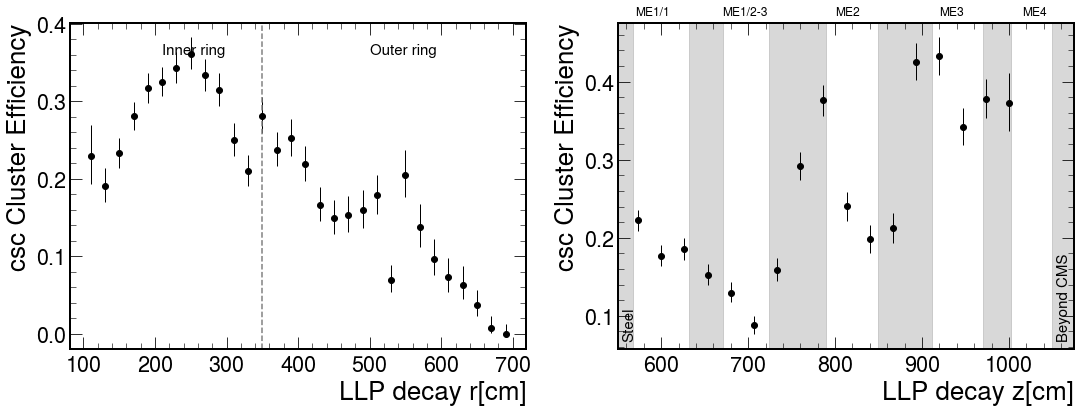

In [122]:
figsize = (18,6)
fig, (cscrax, csczax) = plt.subplots(1,2,figsize = figsize)

csc = out['hnl']['hists2d']['csc_cls_csc_llps_pairs_dr_cut_csc_llps']
cscllp = out['hnl']['hists2d']['csc_llps']

ratio(csc, cscllp, csczax, 'z', 'csc')
drawCSCz(csczax)

ratio(csc, cscllp, cscrax, 'r', 'csc')
drawCSCr(cscrax)


In [123]:
def ratio2(reco, real, rax, det):
    num = reco
    den = real
    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "efficiency"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    rax.set_ylabel(f"{det} Cluster Efficiency")
    rax.set_xlabel(f"LLP decay E [GeV]")
    return rax

/tmp/ipykernel_30056/4178255298.py:6: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


<AxesSubplot:xlabel='LLP decay E [GeV]', ylabel='csc Cluster Efficiency'>

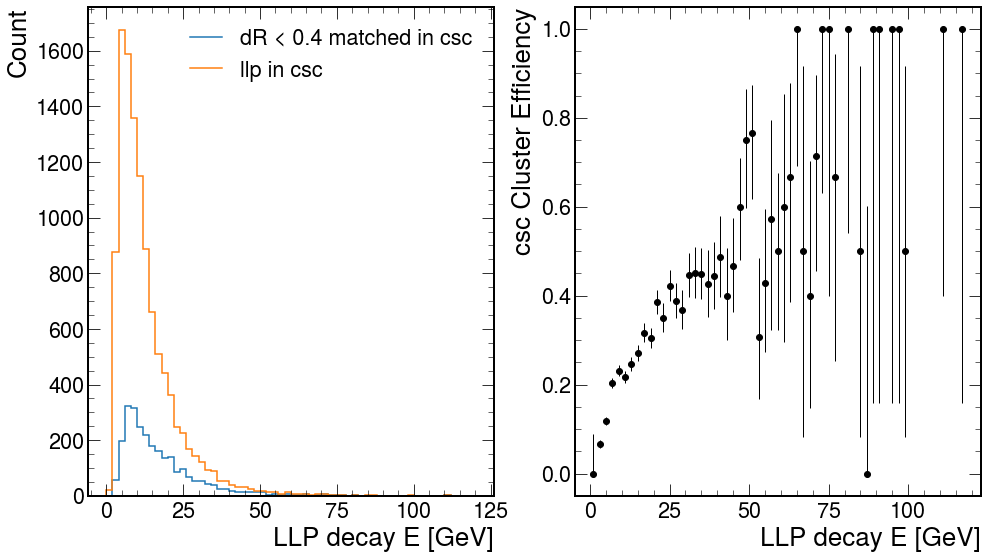

In [124]:
den = out['hnl']['hists1d']['csc_llps']['E']

num = out['hnl']['hists1d']['csc_cls_csc_llps_pairs_dr_cut_csc_llps']['E']

figsize = (16,9)
fig, ax = plt.subplots(1,2,figsize = figsize)
hep.histplot(num, ax = ax[0], label = 'dR < 0.4 matched in csc')
hep.histplot(den, ax = ax[0], label = 'llp in csc')
ax[0].set_xlabel(f"LLP decay E [GeV]")
ax[0].set_ylabel(f"Count")
ax[0].legend()

ratio2(num, den, ax[1], 'csc')


/tmp/ipykernel_30056/550440144.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_30056/550440144.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_30056/550440144.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,
/tmp/ipykernel_30056/550440144.py:13: RuntimeWarning: invalid value encountered in true_divide
  y=num.view() / den.view() ,


cut: csc_cls_time_cut,	 nevents: 7491.0,	 efficiency: 0.55624860770773,	 cumulative efficiency: 0.55624860770773
cut: csc_cls_ME1112_veto,	 nevents: 907.0,	 efficiency: 0.06734981807381006,	 cumulative efficiency: 0.02083887649915696
cut: csc_cls_Eta_cut,	 nevents: 595.0,	 efficiency: 0.04418207470112126,	 cumulative efficiency: 6.200930065664857e-05
cut: csc_cls_timeSpread_cut,	 nevents: 570.0,	 efficiency: 0.042325685007796834,	 cumulative efficiency: 1.1595966032913868e-07


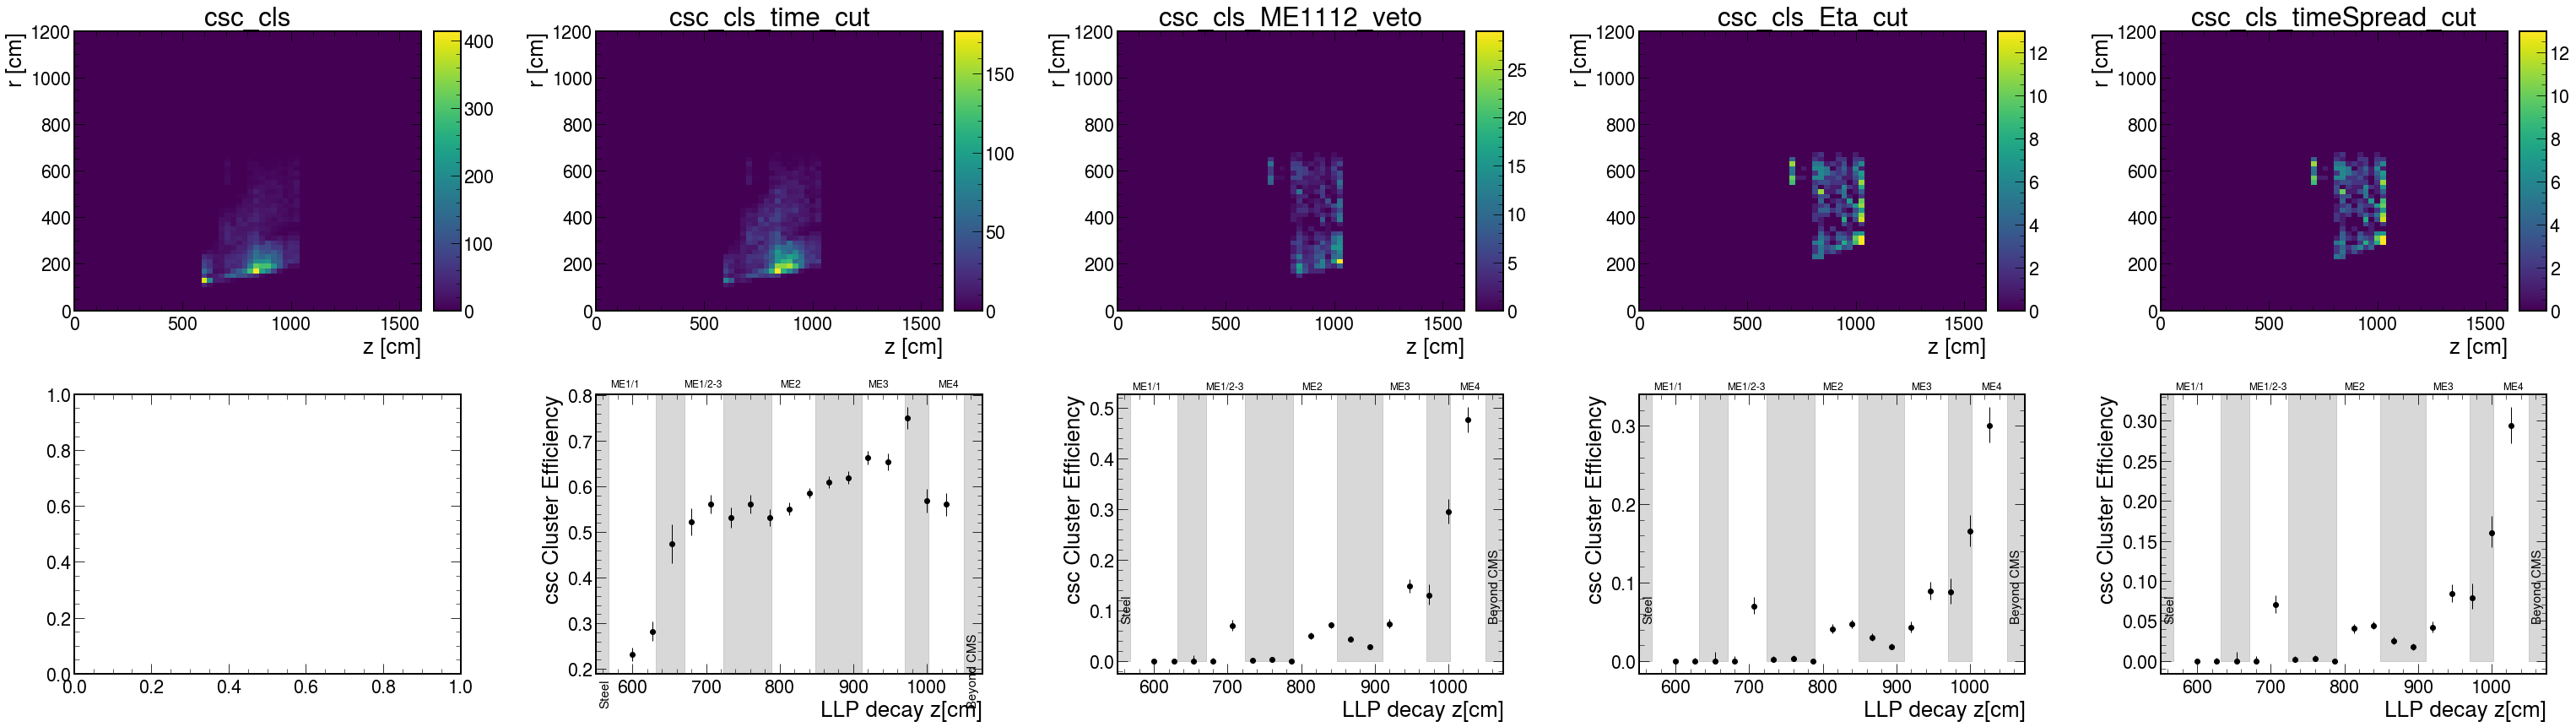

In [143]:
import mplhep
from hist.intervals import ratio_uncertainty
import matplotlib.patches as patches

plt.style.use(mplhep.style.CMS)


def ratio(reco, real, rax, ax, det):
    num = reco.project(ax)
    den = real.project(ax)
    rax.errorbar(
        x=num.axes[0].centers,
        y=num.view() / den.view() ,
        yerr=ratio_uncertainty(num.view(), den.view(), "efficiency"),
        color="k",
        linestyle="none",
        marker="o",
        elinewidth=1,
    )
    rax.set_ylabel(f"{det} Cluster Efficiency")
    rax.set_xlabel(f"LLP decay {ax}[cm]")
    return rax

def drawCSCz(ax,text_loc=0.7):    
    ax.set_xlim(550,1075)
    (xmin,xmax) = ax.get_xlim()

    y_max = ax.get_ylim()[1]

    preME11 = patches.Rectangle((xmin, 0), 568-xmin, 2,color='grey',alpha=0.3)
    ME11_12 = patches.Rectangle((632, 0), 39, 2,color='grey',alpha=0.3)
    ME12_2  = patches.Rectangle((724, 0), 65, 2,color='grey',alpha=0.3)
    ME2_3   = patches.Rectangle((849, 0), 62, 2,color='grey',alpha=0.3)
    ME3_4   = patches.Rectangle((970, 0), 32, 2,color='grey',alpha=0.3)
    beyond  = patches.Rectangle((1050, 0),50, 2,color='grey',alpha=0.3)

    ax.text(570, y_max*1.02, 'ME1/1', fontsize=12)
    ax.text(670, y_max*1.02, 'ME1/2-3', fontsize=12)
    ax.text(800, y_max*1.02, 'ME2', fontsize=12)
    ax.text(920, y_max*1.02, 'ME3', fontsize=12)
    ax.text(1015, y_max*1.02,'ME4', fontsize=12)
    ax.text(xmin+5 ,y_max*0.15, "Steel", fontsize=15,rotation=90)
    ax.text(xmax-20,y_max*0.15, "Beyond CMS", fontsize=15,rotation=90)

    ax.add_patch(preME11)
    ax.add_patch(ME11_12)
    ax.add_patch(ME12_2)
    ax.add_patch(ME2_3)
    ax.add_patch(ME3_4)
    ax.add_patch(beyond)
    return ax

def drawCSCr(ax):
    y_max = ax.get_ylim()[1]
    ax.axvline(350,linestyle="--",color='grey')
    ax.text(350-140,y_max*0.9, "Inner ring", fontsize=15)
    ax.text(350+150 ,y_max*0.9, "Outer ring", fontsize=15)

nameList = ['csc_cls', 'csc_cls_time_cut', 'csc_cls_ME1112_veto', 'csc_cls_Eta_cut', 'csc_cls_timeSpread_cut']

a = 7
figsize = (len(nameList)*a*1.5,2*a)
fig, axes = plt.subplots(2,len(nameList),figsize = figsize)
fig.subplots_adjust(wspace=.35, hspace = 0.3)

prevEff = 1
Eff = 1
cumEff = 1
nevents = 1

for name in nameList:
    num = out['hnl']['hists2d'][name]
    den = out['hnl']['hists2d']['csc_cls']

    ax = axes[:,nameList.index(name)]
    hep.hist2dplot(num, ax = ax[0])
    ax[0].set_title(f"{name}")

    if name != 'csc_cls':
        ratio(num, den, ax[1], 'z', 'csc')
        drawCSCz(ax[1])
        Eff = num.sum()/den.sum()
        cumEff *= prevEff*Eff
        prevEff = Eff
        nevents = num.sum()
        print(f'cut: {name},\t nevents: {nevents},\t efficiency: {Eff},\t cumulative efficiency: {cumEff}')


    


In [119]:
out['hnl']['hists2d']['csc_cls'].sum()

13467.0